# Climate 323 Final Project

# Periodic Behavior of Magnetopause Standoff Distance
### Team Members
* Carson Clark
* Mya Enzer
* Satwika Tattari

## Background
The magnetosphere shields the Earth against radiation and is created by our planet’s magnetic field. Its shape is dictated by the magnetosphere’s interactions with solar wind, causing it to look similar to a comet or bullet. The end of the magnetosphere (boundary to solar wind) is referred to as the magnetopause. The magnetopause is very dynamic and is constantly changing due to interactions with solar wind. Essentially, the magnetopause standoff distance (distance between the center of the Earth and the end of the magnetosphere) increases and decreases due to pressure from solar wind on the magnetopause. The distance can be calculated using the Shue formula. Solar wind strength from the Sun can be categorized using 11-year solar cycles. During solar maximums, the Sun has increased activity and releases a lot more energy towards Earth through solar wind and there are more solar storms. It is important to note that the solar cycles are categorized by the number of sunspots counted on the Sun. The number of sunspots is directly associated with the Sun’s level of activity and therefore where it is in the solar cycle. This information will be used to form our hypothesis on the periodicity of variation in the magnetopause standoff distance.   Another parameter we will look at is the Dst index - Disturbance Storm Time Index - which explains the measure of the intensity of magnetic variations at the equator.  Also, we will be using the Shue et. al formula which uses solar wind pressure (measure of the pressure exerted on the magnetosphere by solar wind) and Bz (measure of the vertical (z) component of the magnetic field) to estimate the magnetopause standoff distance. Important to note that this is an empirical formula found from observations so it has limitations.

## Goals
The main goal of this project is to determine the magnetopause standoff distance and plot this value over a long period of time. From there, we want to determine the periodic behavior of the standoff distance, and compare this behavior with the solar cycle to see how solar maximum and minimum affect the magnetopause. To determine this behavior, we will use harmonic analysis and fast fourier transforms as described in the data section. In particular, we want to examine times where the standoff distance crosses inside geosynchronous orbit at 6.61 Earth radii, and relate these events to the current stage of the solar cycle. We will also be examining some specific times where the Dst index is very large, and determining whether these events push the magnetopause into GEO or even closer into something like the semi-synchronous orbit at 3.17 Earth radii. One of our research questions will be “What is the periodic trend of the magnetopause standoff distance crossing into GEO?” Another research question we want to answer is, “How does the variation in magnetopause standoff distance compare to stages of the solar cycle?”

## Data
For this project, the data we used is taken from the NASA sponsored Coordinated Data Analysis web (CDAWeb), which contains data from many heliophysics missions, both past and current. We are using the data from the OMNI data set, which compiles and cross-compares data from many different spacecraft in geocentric and L1 orbits. Our data starts on January 1st. 1986, and ends January 31st, 2020. The dataset includes the Datetime, magnetic field strength in z-direction, solar wind pressure, number of sunspots, and the Dst.

----

## Approach
We start with code that imports the necessary libraries, sets up our variable names, reads in the data, and creates a datetime object.

In [1]:
# Importing necessary libraries
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.dates import date2num
from matplotlib.dates import num2date

%matplotlib inline
plt.style.use('fivethirtyeight')

varnames = ['Date', 'Bz', 'Pressure', 'Sunspots', 'DST'] #setting own varnames 

In [2]:
#read in new data
tconvert = lambda x: dt.datetime.strptime(str(x), '%m/%d/%Y')
adata = np.genfromtxt('./anom5j.csv', delimiter=',', names = True, converters={0: tconvert}, 
                          encoding='utf-8', dtype = None, skip_header=0)
print(adata[0])

(datetime.datetime(1990, 9, 11, 0, 0), 35784)


In [3]:
#Reading in data
def tconvert(x):
    # Extract year, month, day, hour from the datetime string
    #REFERENCEE
    year = int(x[:4])
    month = int(x[5:7])
    day = int(x[8:10])
    hour = int(x[11:13])
    # Create a datetime object with the extracted values
    return dt.datetime(year, month, day, hour)

#reading in data using genfromtxt and skipping unecessary rows
data = np.genfromtxt('OMNI2_H0_MRG1HR_2258698.csv', delimiter=',', names = varnames, converters={0: tconvert}, 
                          encoding='utf-8', skip_header=103, dtype = None)

print(data[0])


(datetime.datetime(1986, 1, 1, 0, 0), 999.9, 99.99, 0, -25)


Because some of the pressure values are zero in the dataset, we replace these zero-values with a very small value, then create a masked array. This is also where we use the Shue et al. formula to calculate the standoff distance.

In [4]:
# Replace zero values in 'Pressure' with a small non-zero value so that we don't divide by 0 (these will be masked later)
data['Pressure'] = np.where(data['Pressure'] == 0, 0.00001, data['Pressure'])

#Shue et al. formula
magpause_dist = (10.22 + 1.29 * np.tanh(0.184 * (data['Bz'] + 8.14))) * (1. / data['Pressure']) ** (1. / 6.6)

#masked array where magnetopause standoff distance is masked for invalid Bz or Pressure values
#REFERENCEE
magpause_dist_mask = np.ma.masked_where((data['Bz'] == 999.9) | (data['Pressure'] == 99.99) | (data['Pressure'] == 0), 
                                  magpause_dist)



For our first graph, we calculate the three year running mean of the standoff distance, and then plot it along with the entire time series. We see that the running mean starts a bit lower for the first few years, at around 7.5 Earth radii, then increases to about 10 Earth radii.

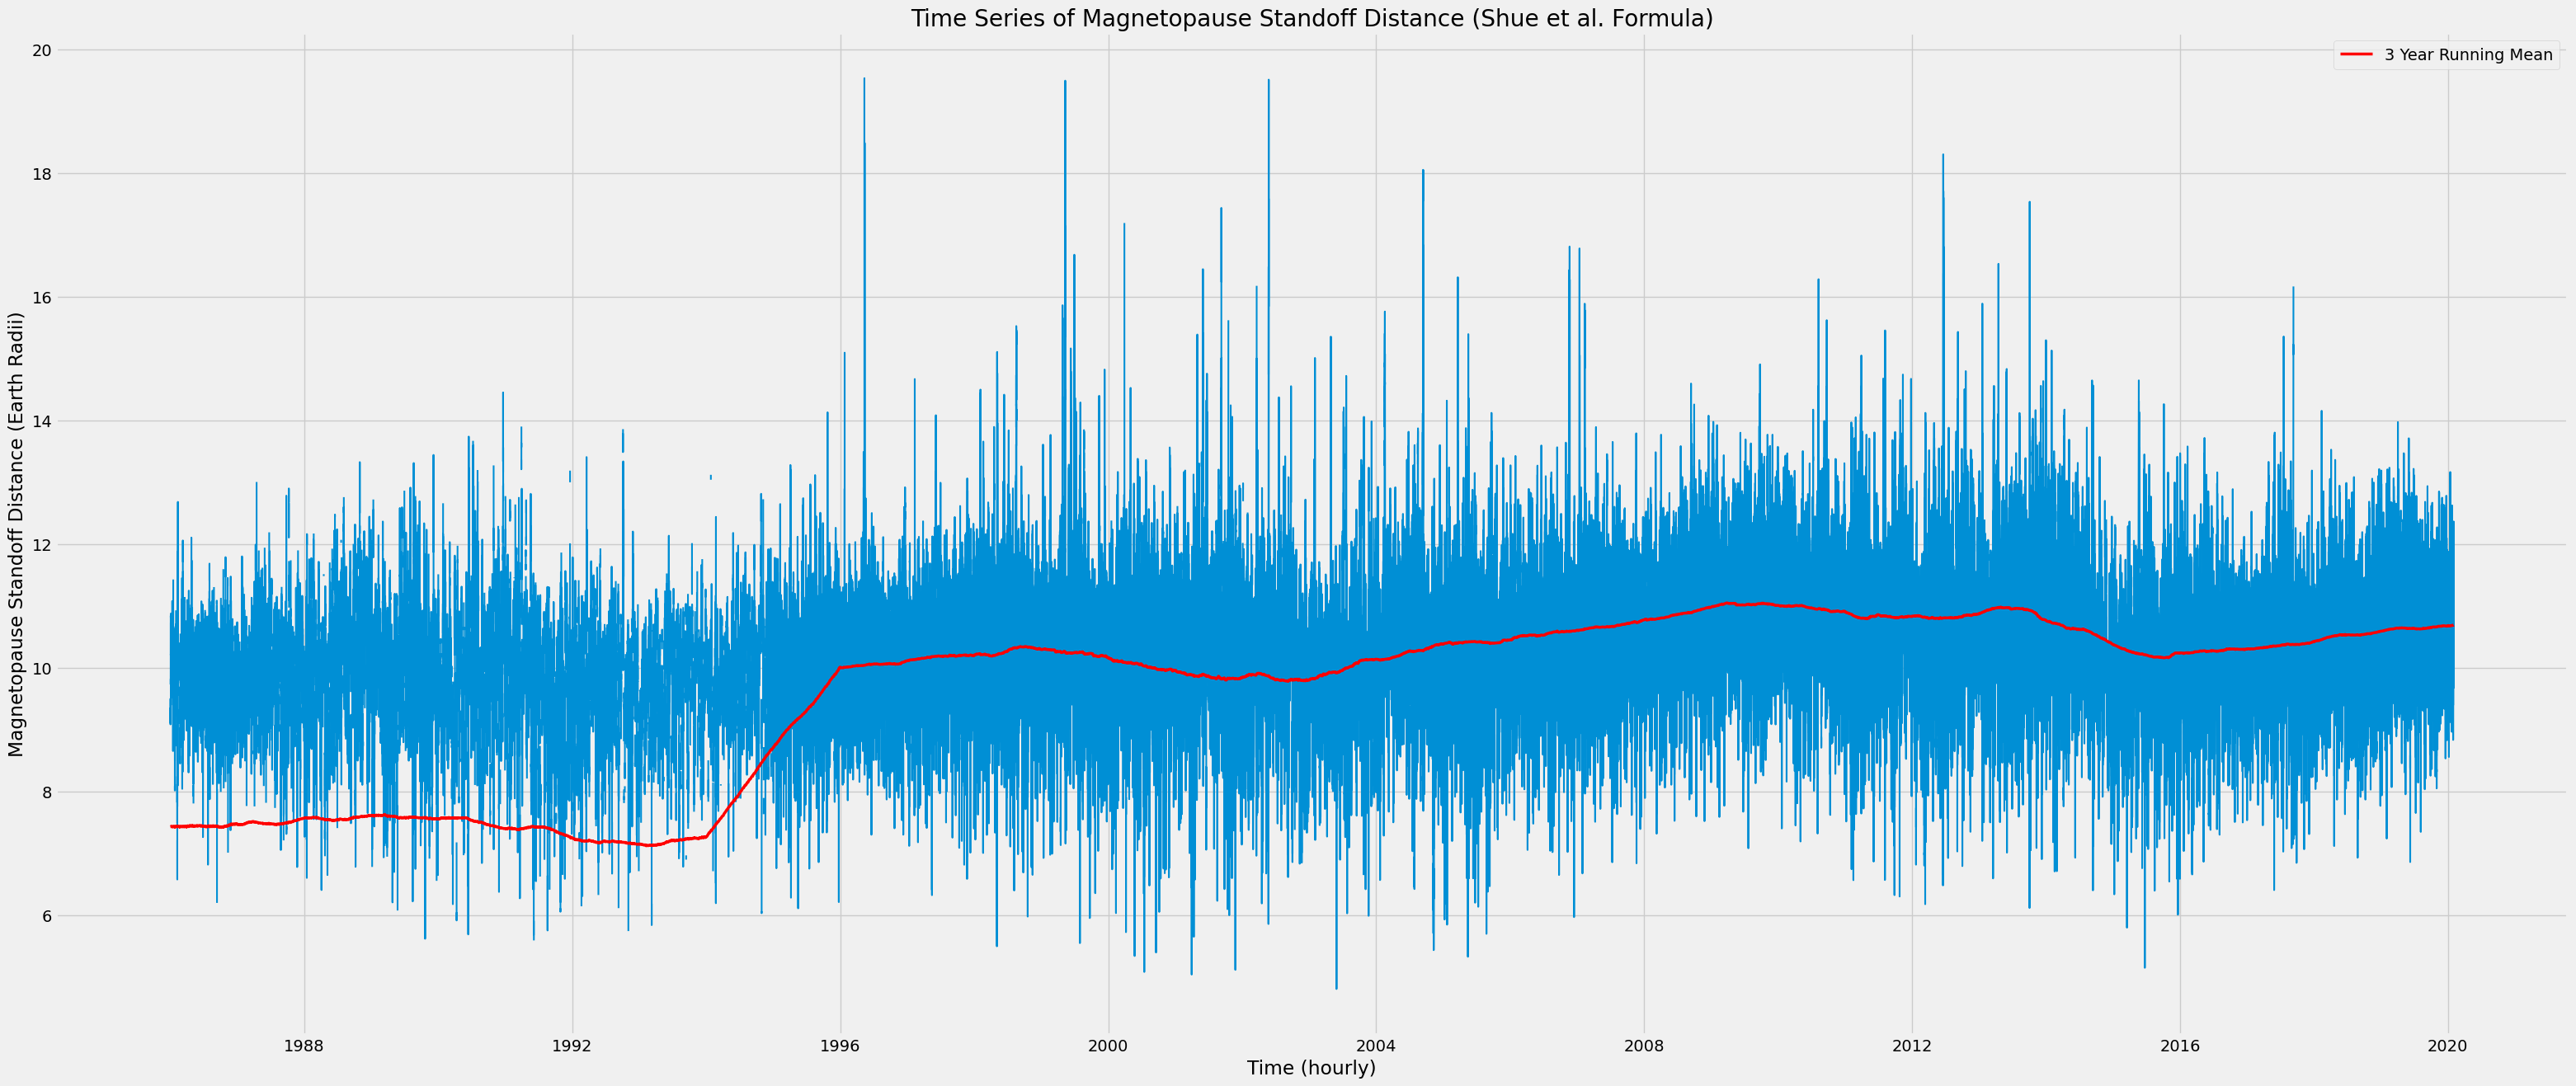

In [5]:
# Calculate the three year mean of the sunspot number
from scipy.ndimage import uniform_filter1d
three_year_mean = uniform_filter1d(magpause_dist_mask , size= 17520)

# Regular setting up figure and formatting graph code
fig = plt.figure(figsize=(35, 15))

plt.plot(data['Date'], magpause_dist_mask, linewidth = 1.5 )
plt.plot(data['Date'], three_year_mean, label='3 Year Running Mean', color = 'red', lw = 2.5)
plt.title("Time Series of Magnetopause Standoff Distance (Shue et al. Formula)")
plt.xlabel("Time (hourly)")
plt.ylabel("Magnetopause Standoff Distance (Earth Radii)")
plt.legend()

Frequency associated with max amplitude: 0.029319624066190056
The period associated with the largest amplitude is 34.106849315068494


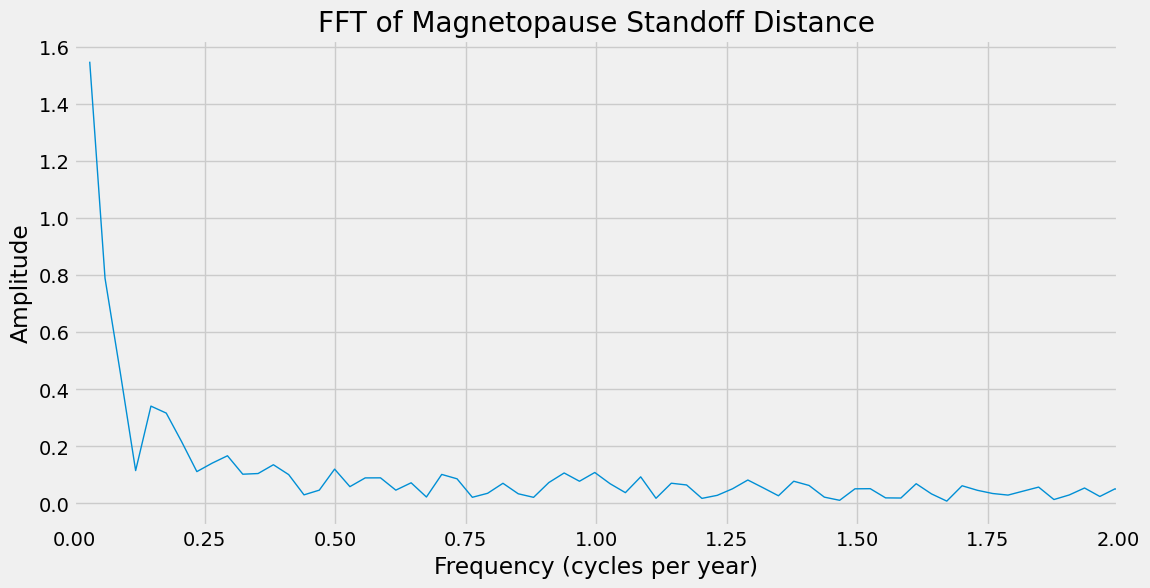

In [6]:
from scipy.fftpack import fft, fftfreq

dt_mag_dist = 1/8760 # Units of fraction of a year
N_mag_dist = len(data) # Length of time series (duration * time step)



magpause_dist_ft = fft(magpause_dist_mask) # Get transform
freqs_mag_dist = fftfreq(N_mag_dist, dt_mag_dist) # Get frequency bins associated with the FT.

positive_freqs_mask = freqs_mag_dist > 0
pos_freqs_mag_dist = freqs_mag_dist[positive_freqs_mask]
pos_data_mag_dist = magpause_dist_ft[positive_freqs_mask]

fig = plt.figure(figsize=(12, 6))
plt.plot(pos_freqs_mag_dist[:N_mag_dist//2], 2.0/N_mag_dist * np.abs(pos_data_mag_dist[:N_mag_dist//2]), '-', lw=1)
#plt.plot(pos_freqs_mag_dist)



plt.xlabel('Frequency (cycles per year)')
plt.ylabel('Amplitude')
plt.title('FFT of Magnetopause Standoff Distance')

plt.xlim(0,2)

max_amplitude_index = np.argmax(np.abs(pos_data_mag_dist[:N_mag_dist//2]))

# Retrieve the corresponding frequency
max_frequency = pos_freqs_mag_dist[max_amplitude_index]
period = 1/max_frequency

print("Frequency associated with max amplitude:", max_frequency)
print(f"The period associated with the largest amplitude is {period}")


Next, we do the same thing for the sunspot number, calculating the three year mean and then plotting it alongside the total time series. Here we can clearly see a periodic cycle that seems to be around 11 years, but we will examine that in detail in the next cell.

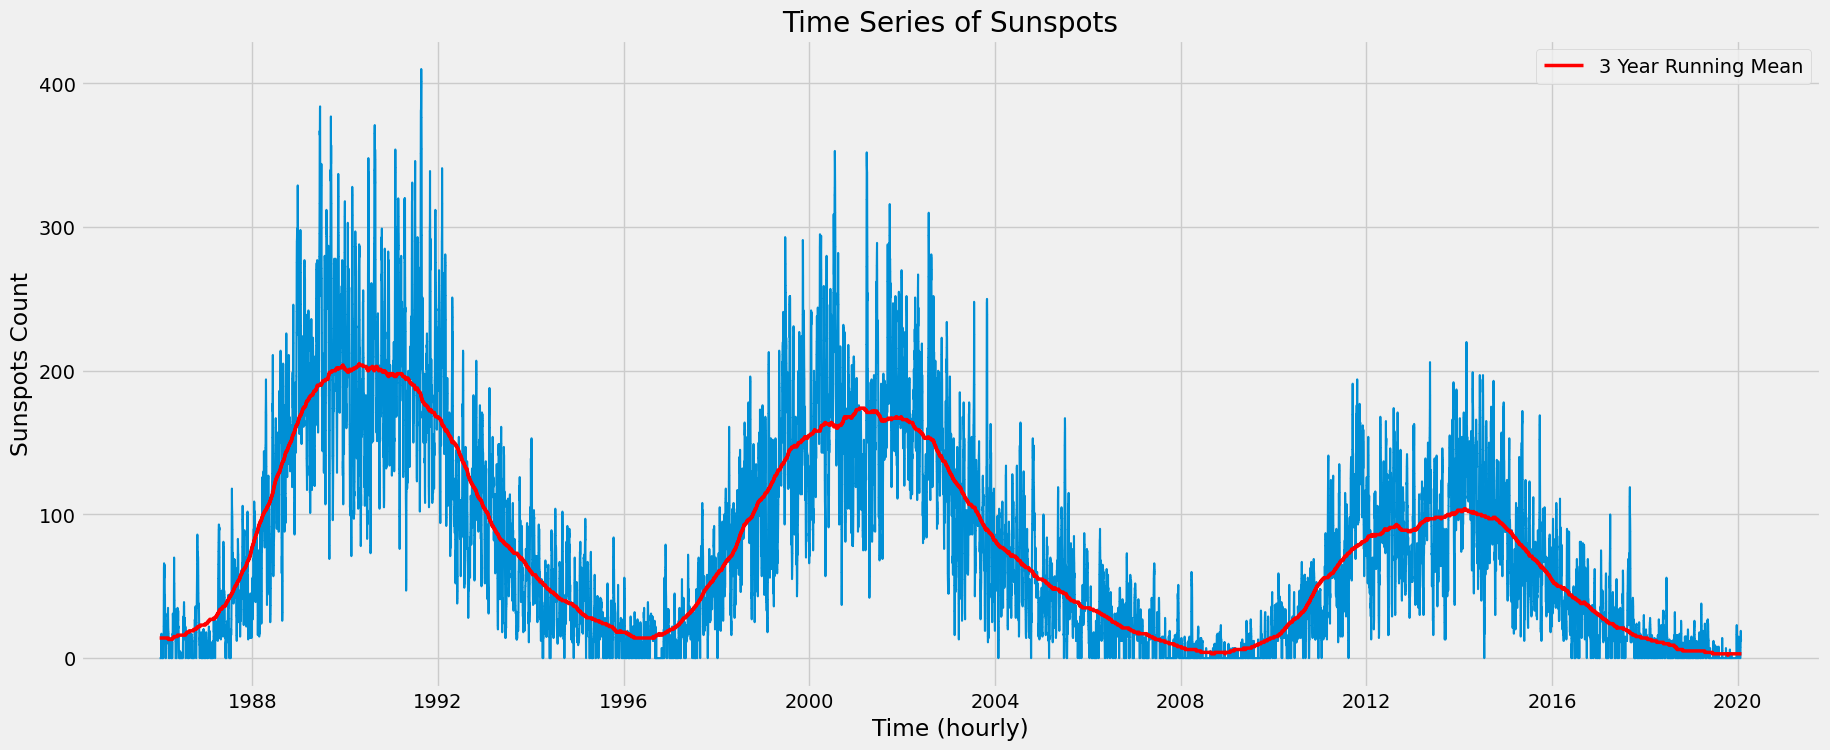

In [7]:
# Calculate the three year mean of the sunspot number
from scipy.ndimage import uniform_filter1d
three_year_mean = uniform_filter1d(data['Sunspots'] , size= 17520)

# Setting up graph
fig = plt.figure(figsize=(20, 8))

plt.plot(data['Date'], data['Sunspots'], linewidth = 1.5 )
plt.plot(data['Date'], three_year_mean, label='3 Year Running Mean', color = 'red', lw = 2.5)
plt.title("Time Series of Sunspots")
plt.xlabel("Time (hourly)")
plt.ylabel("Sunspots Count")
plt.legend()

Next, we conduct an FFT of the sunspot number. We end up with a period of 11.369 years, which is very close to what we would expect the length of the solar cycle to be.

Frequency associated with max amplitude: 0.08795887219857017
The period associated with the largest amplitude is 11.368949771689497


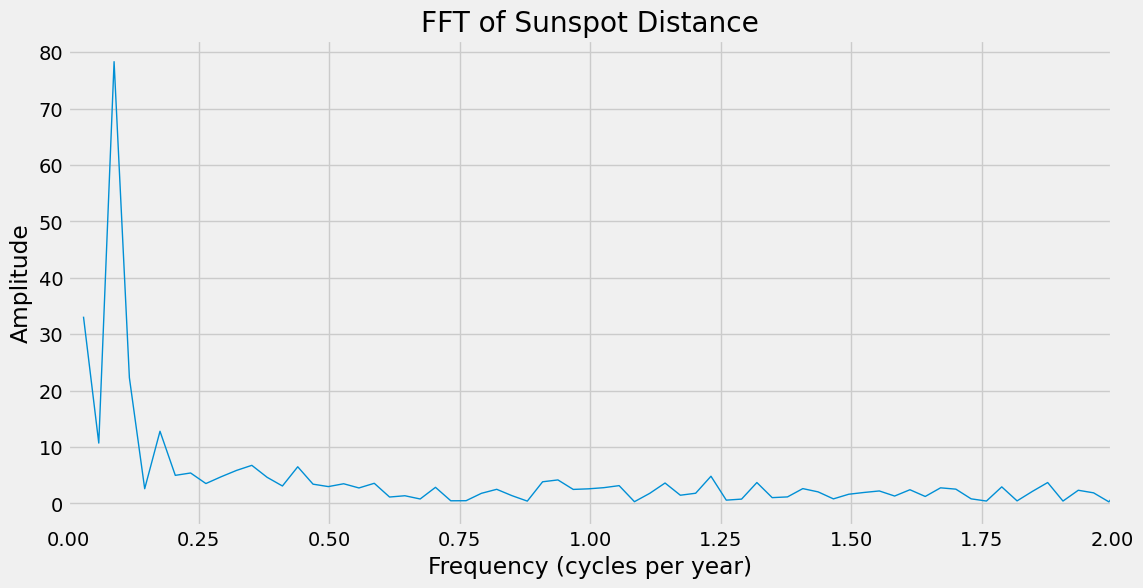

In [8]:
from scipy.fftpack import fft, fftfreq

dt_mag_dist = 1/8760 # Units of fraction of a year
N_mag_dist = len(data) # Length of time series (duration * time step)



magpause_dist_ft = fft(data['Sunspots']) # Get transform
freqs_mag_dist = fftfreq(N_mag_dist, dt_mag_dist) # Get frequency bins associated with the FT.

positive_freqs_mask = freqs_mag_dist > 0
pos_freqs_mag_dist = freqs_mag_dist[positive_freqs_mask]
pos_data_mag_dist = magpause_dist_ft[positive_freqs_mask]

fig = plt.figure(figsize=(12, 6))
plt.plot(pos_freqs_mag_dist[:N_mag_dist//2], 2.0/N_mag_dist * np.abs(pos_data_mag_dist[:N_mag_dist//2]), '-', lw=1)
#plt.plot(pos_freqs_mag_dist)



plt.xlabel('Frequency (cycles per year)')
plt.ylabel('Amplitude')
plt.title('FFT of Sunspot Distance')

plt.xlim(0,2)

max_amplitude_index = np.argmax(np.abs(pos_data_mag_dist[:N_mag_dist//2]))

# Retrieve the corresponding frequency
max_frequency = pos_freqs_mag_dist[max_amplitude_index]
period = 1/max_frequency

print("Frequency associated with max amplitude:", max_frequency)
print(f"The period associated with the largest amplitude is {period}")


## GEO Crossing 
Next, we will be calculating when the magnetopause is inside Geosynchronous Orbit and studying the frequency.

In [9]:
#Going back to the masked values which are invalid, I am setting all of them to 10 so that it will count as not crossing GEO 
#REFERENCEEE
magpause_dist_filtered = np.ma.filled(magpause_dist_mask, fill_value=10.0) #here I am filling all the masked values to 10

# Create geo_crossing array based on magpause_dist
geo_crossing = np.where(magpause_dist_filtered < 6.6, 1, 0)

# Create a new array with the time column from the data dataset and another column with the geo_crossing values
geo_data = np.column_stack((data['Date'], geo_crossing))

# Initialize a dictionary to store the sum of geo_crossing values for each month of each year
sum_geo_crossing_daily = {}

# Iterate over the rows of geo_data
for row in geo_data:
    # Extract year and month from the date column (assuming it's the first column)
    year_month_day = (row[0].year, row[0].month, row[0].day)
    
    # Get the corresponding geo_crossing value (assuming it's the second column)
    geo = row[1]
    
    # Update the sum for the current day, month, and year
    sum_geo_crossing_daily[year_month_day] = sum_geo_crossing_daily.get(year_month_day, 0) + geo






Text(0, 0.5, 'Hours Inside GEO')

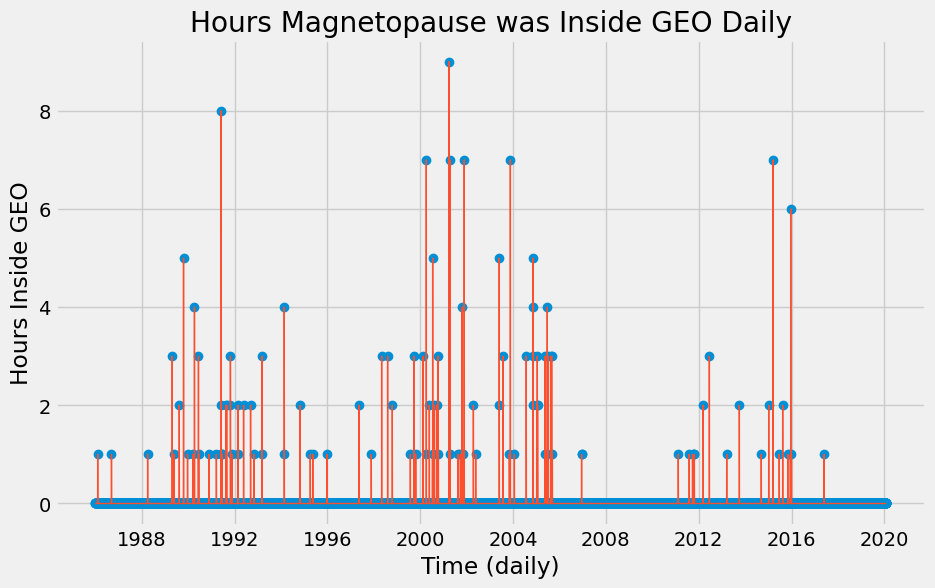

In [10]:
# Extracting dates from sum_geo_crossing_daily keys
dates = [dt.datetime(year, month, day) for year, month, day in sum_geo_crossing_daily.keys()]

# Extracting the daily sums of geo crossings
daily_sums = list(sum_geo_crossing_daily.values())

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(dates, daily_sums, marker='o', linestyle='None')
plt.plot(dates, daily_sums, '-', lw=1)
plt.title('Hours Magnetopause was Inside GEO Daily')
plt.xlabel('Time (daily)')
plt.ylabel('Hours Inside GEO')

In [11]:
print(len(dates))

12449


Frequency associated with max amplitude: 0.08795887219857017
The period associated with the largest amplitutde is 11.368949771689497


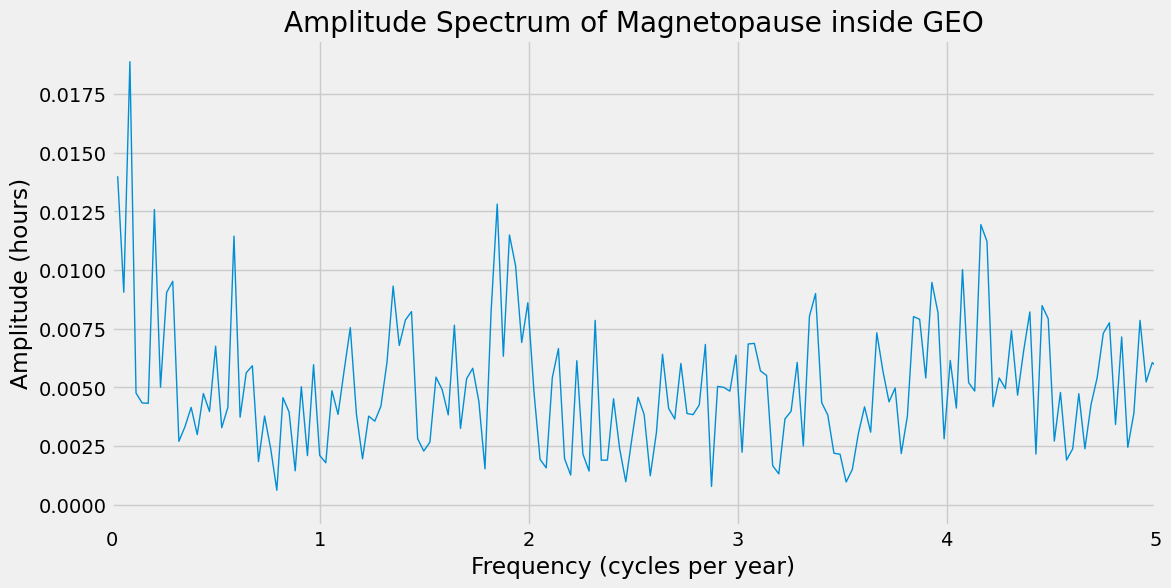

In [12]:
dt = 1/365 # Units of fraction of a year
N = len(dates) # Length of time series (duration * time step)

crossing_daily = np.array(list(sum_geo_crossing_daily.values()))

geo_crossing_ft = fft(crossing_daily) # Get transform
freqs = fftfreq(N, dt) # Get frequency bins associated with the FT.

positive_freqs_mask = freqs > 0
pos_freqs = freqs[positive_freqs_mask]
pos_data = geo_crossing_ft[positive_freqs_mask]

fig = plt.figure(figsize=(12, 6))
plt.plot(pos_freqs[:N//2], 2.0/N * np.abs(pos_data[:N//2]), '-', lw=1)



plt.xlabel('Frequency (cycles per year)')
plt.ylabel('Amplitude (hours)')
plt.title('Amplitude Spectrum of Magnetopause inside GEO')

plt.xlim(0,5)

max_amplitude_index = np.argmax(np.abs(pos_data[:N//2]))

# Retrieve the corresponding frequency
max_frequency = pos_freqs[max_amplitude_index]
period = 1/max_frequency

print("Frequency associated with max amplitude:", max_frequency)
print(f"The period associated with the largest amplitutde is {period}")


0.08106727361102577 0.05662677197379573


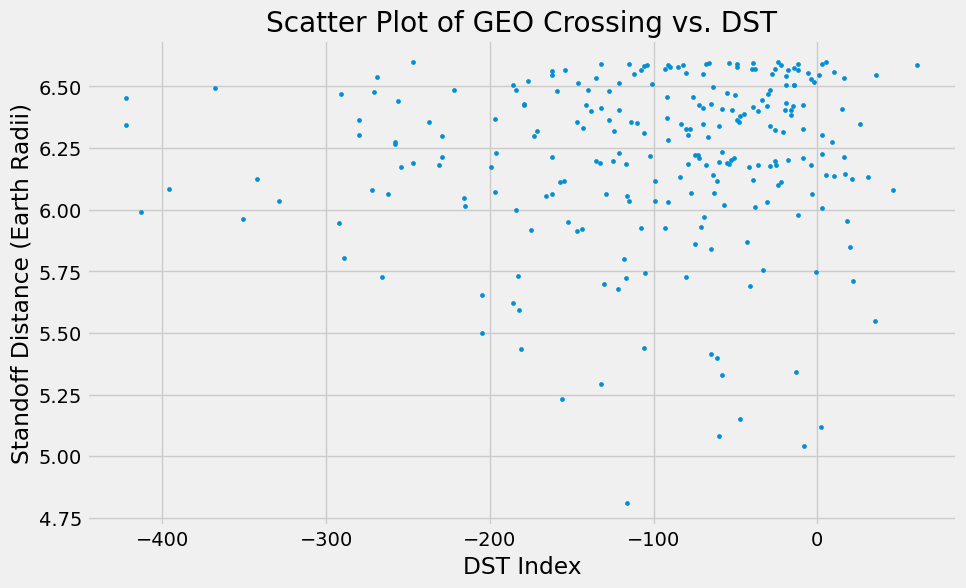

In [13]:
dst_values = data['DST']
geo_crossing_hours = np.where(geo_crossing == 1)[0]

# Extract magnetopause standoff distance and DST values for those hours
magpause_dist_geo1 = magpause_dist_mask[geo_crossing_hours]
dst_geo1 = dst_values[geo_crossing_hours]

# Plot the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(dst_geo1, magpause_dist_geo1, marker='o', s = 8)
plt.title('Scatter Plot of GEO Crossing vs. DST')
plt.ylabel('Standoff Distance (Earth Radii)')
plt.xlabel('DST Index')

from scipy.stats import kendalltau
kendall_tau, p_value = kendalltau(dst_geo1, magpause_dist_geo1 )

print(kendall_tau, p_value)

0.10846550524254839 6.528693821184666e-88


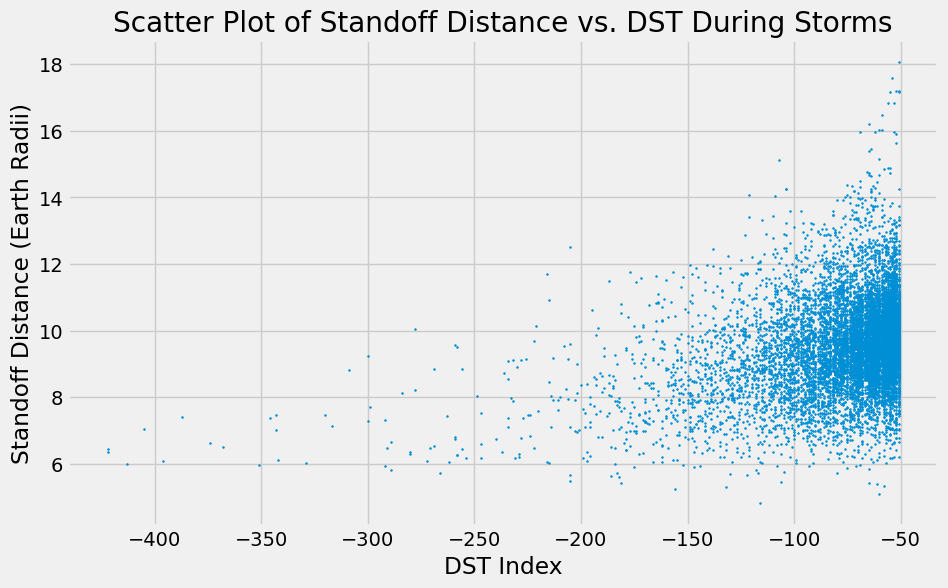

In [14]:
dst_values = data['DST']
storm_times = np.where(data['DST'] < -50)[0]

# Extract magnetopause standoff distance and DST values for those hours
magpause_dist_storm = magpause_dist_mask[storm_times]
dst_storm = dst_values[storm_times]

# Plot the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(dst_storm, magpause_dist_storm, marker='o', s = 1.5)
plt.title('Scatter Plot of Standoff Distance vs. DST During Storms')
plt.ylabel('Standoff Distance (Earth Radii)')
plt.xlabel('DST Index')


kendall_tau, p_value = kendalltau(dst_storm, magpause_dist_storm)
print(kendall_tau, p_value)

Another possible correlation we wanted to examine was between a GEO crossing happening and the current number of sunspots. We used a very similar technique as to the previous analysis with Dst, plotting the values on a scatter plot and finding the Kendall Tau and p-values. When we look at all GEO crossings, not just the storm time values, we see that both our Kendall Tau value and p-value imply there is basically no correlation between the two values. This is interesting, as we would expect that higher number of sunspots would correspond with more solar activity, leading to more GEO crossings.

-0.07108637859204621 0.09688293049909526


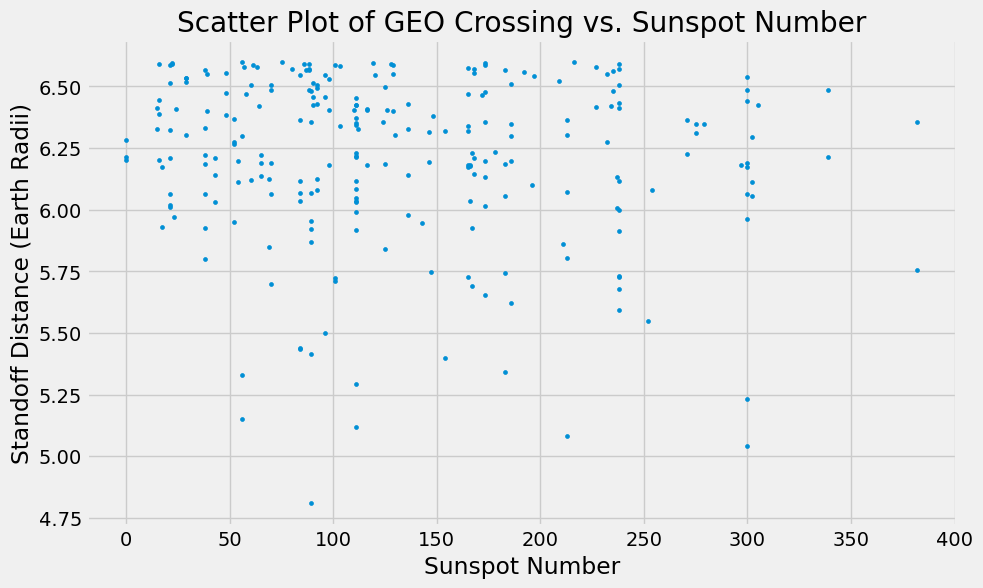

In [15]:
sunspot_numbers = data['Sunspots']
geo_crossing_hours = np.where(geo_crossing == 1)[0]

# Extract magnetopause standoff distance and DST values for those hours
magpause_dist_geo1 = magpause_dist_mask[geo_crossing_hours]
sunspot_geo1 = sunspot_numbers[geo_crossing_hours]

# Plot the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(sunspot_geo1, magpause_dist_geo1, marker='o', s = 8)
plt.title('Scatter Plot of GEO Crossing vs. Sunspot Number')
plt.ylabel('Standoff Distance (Earth Radii)')
plt.xlabel('Sunspot Number')

from scipy.stats import kendalltau
kendall_tau, p_value = kendalltau(sunspot_geo1, magpause_dist_geo1 )

print(kendall_tau, p_value)

Similarly to the Dst analysis, we also wanted to look at GEO crossing when a storm was occurring, which we classified as Dst < -50. We still have a very weak Kendall Tau value, but we now have a very small p-value that we can call statistically significant. This could imply that there is no correlation between the sunspot number and amount of GEO crossings.

-0.11861195300652284 2.3493494744625844e-106


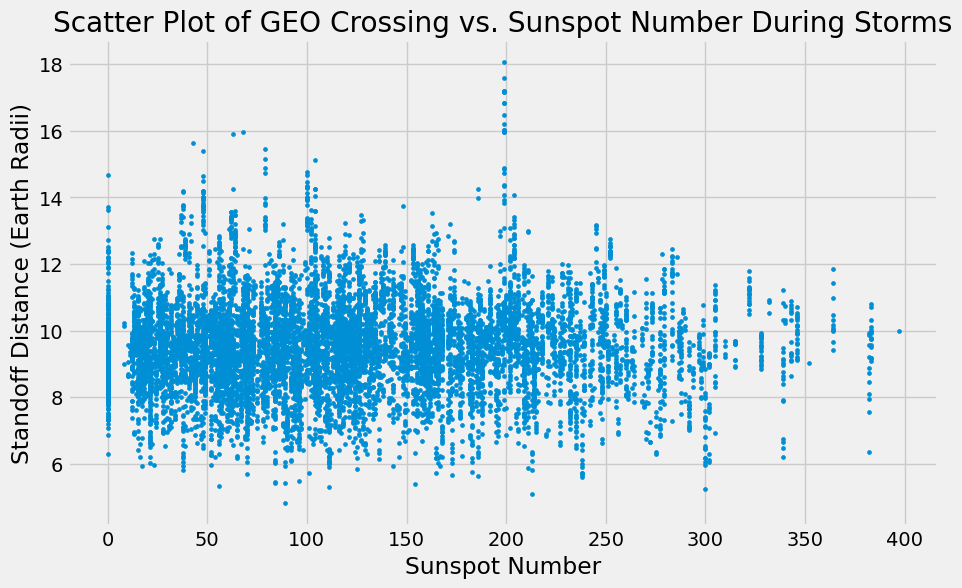

In [16]:
sunspot_numbers = data['Sunspots']
storm_times = np.where(data['DST'] < -50)[0]
#geo_crossing_hours = np.where(geo_crossing == 1)[0]

# Extract magnetopause standoff distance and DST values for those hours
magpause_dist_geo1 = magpause_dist_mask[storm_times]
sunspot_geo1 = sunspot_numbers[storm_times]

# Plot the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(sunspot_geo1, magpause_dist_geo1, marker='o', s = 8)
plt.title('Scatter Plot of GEO Crossing vs. Sunspot Number During Storms')
plt.ylabel('Standoff Distance (Earth Radii)')
plt.xlabel('Sunspot Number')

from scipy.stats import kendalltau
kendall_tau, p_value = kendalltau(sunspot_geo1, magpause_dist_geo1 )

print(kendall_tau, p_value)

## Satelitte Anomalies
Now we'll look at Spacecraft anomalies and how they line up with the changing magnetopause and exposure to solar radiation.

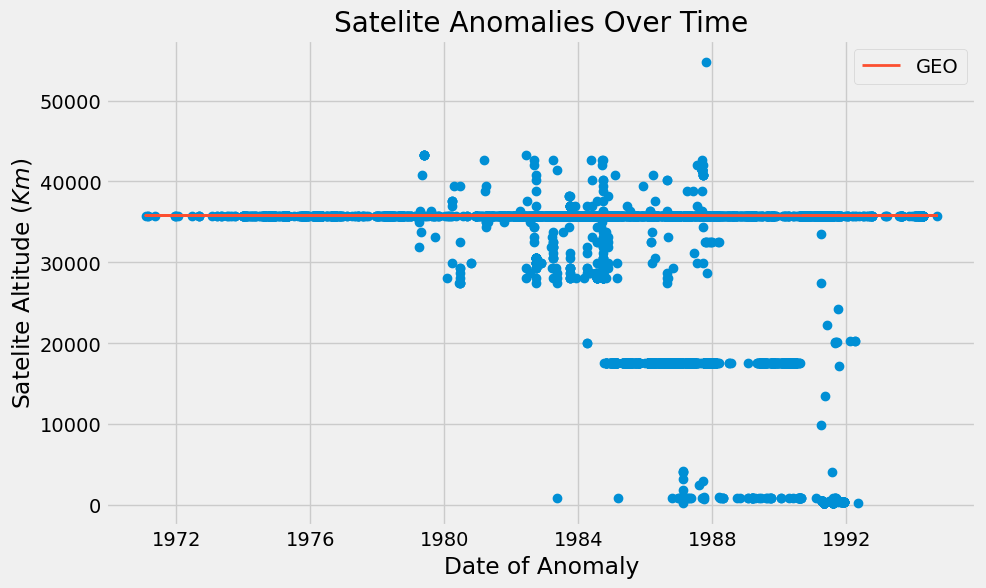

In [17]:
#Give dates a more managable name
adates = adata['\ufeffADATE']

#Mask 0 values
adates = adates[adata['ALT'] > 0]
alts = adata['ALT']
alts = alts[adata['ALT'] > 0]

#GEO
geo = np.full(adates.size, 35786)

#Plot the figure
plt.figure(figsize=(10, 6))
plt.plot(adates, alts, marker='o', linestyle='none')
plt.plot(adates, geo, lw=2, label='GEO')
plt.ylabel('Satelite Altitude ($Km$)')
plt.xlabel('Date of Anomaly')
plt.title('Satelite Anomalies Over Time')
plt.legend()

Text(0, 0.5, 'Number of Anomalies')

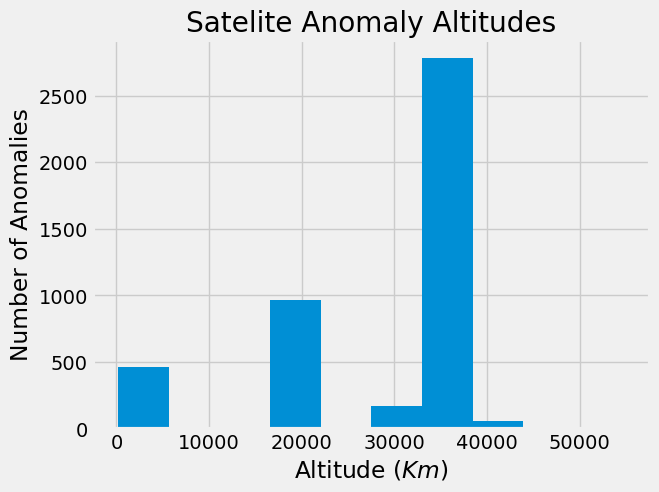

In [18]:
#Ok that's unreadable let's try a bar graph
counts, bins = np.histogram(alts)
plt.stairs(counts, bins, fill=True)
plt.title('Satelite Anomaly Altitudes')
plt.xlabel('Altitude ($Km$)')
plt.ylabel('Number of Anomalies')

As we can see most of the anomalies occur with geosynconus orbiting satelittes, but how do they correlate with the magnetopause distance?

In [19]:
#Convert Km to Earth radii from center
s_height = (alts+6371)/6371 

#Remove Anomalies inside of Magnetopause and before 1988
adates_sm = adates[adates > dt.datetime(1986, 1, 1)]
s_height_sm = s_height[adates > dt.datetime(1986, 1, 1)]
adates_sm = adates_sm[s_height_sm > np.min(magpause_dist_mask)]
s_height_sm = s_height_sm[s_height_sm > np.min(magpause_dist_mask)]


cross = np.zeros(s_height_sm.size)
for i in range(cross.size):
    cross[i] = daily_sums[dates == adates_sm[i]]
    
#plt.plot(adates_sm, cross)

adates_sm_n = date2num(adates_sm)

#Ok that's unreadable let's try a bar graph
counts, bins = np.histogram(adates_sm_n)
dbins = num2date(bins)
plt.stairs(counts, dbins, fill=True)
plt.title('Satelite Anomalies Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Anomalies')

print(bins)

AttributeError: 'float' object has no attribute 'datetime'

The anomalies don't corallate too strongly with the magnetopause standoff distance. There does seem to be a spike in anomalies during solar maximum, but this spike is still smaller than the ones we see at the beginning of the data set during solar minimum. Thus the data proves inconclusive as to a direct coralation.

## Discussion and Conclusion
Our analysis shows that the Magnetopause Standoff Distance does not appear to have strong periodicity, although the data may have a small trend towards increasing. While some of our elements show strong corallation with magnetopause standoff distance, they are not all directly related. Sun spot totals and duration of the magnetopause within GEO both are shown to be directly in line with the solar cycle. GEO crossing seemed to have no corralation with sun spot number or DST. For both GEO crossing vs Sunspot number during storms and Standoff Distance vs DST during storms, while the actual numbers showed low corralation values, a visual examination of the data shows that their may be a stronger relation, particularly at the higher values. While satellite anomalies do appear to be more frequent at GEO, there does not seem to be a strong corallation with the solar cycle or GEO crossings. 